In [1]:
x=1

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [4]:
light_cmap = cmap_map(lambda x: x/2 + 0.5, matplotlib.cm.YlGnBu)

In [5]:
df_type = {
    'ARI': 'Bio conservation',
    'NMI': 'Bio conservation',
    'Label ASW': 'Bio conservation',
    'Isolated label ASW': 'Bio conservation',
    'Batch ASW': 'Batch correction',
    'Graph Connectivity': 'Batch correction',
    'Bio conservation': 'Aggregate score',
    'Batch correction': 'Aggregate score',
    'Total': 'Aggregate score',
}
df_type = pd.DataFrame(df_type, index=['Metric Type'])
df_type

,ARI,NMI,Label ASW,Isolated label ASW,Batch ASW,Graph Connectivity,Bio conservation,Batch correction,Total
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [43]:
df_mtm = pd.read_csv('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/multimil_reproducibility/pipeline/data/metrics/scib_full_pbmc/metrics_mtg1.csv', index_col=0, header=0)
df_mtm = df_mtm.dropna()
df_mtm = df_mtm.T
df_mtm = df_mtm.rename(index={'0': 'MultiMIL'})
df_mtm

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn,batch,bio,overall
MultiMIL,0.767769,0.726609,0.544768,0.938194,0.560411,0.894775,0.916485,0.649889,0.756527


In [44]:
df_totalvi = pd.read_csv('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/multimil_reproducibility/pipeline/data/metrics/scib_full_pbmc/metrics_totalvi.csv', index_col=0, header=0)
df_totalvi = df_totalvi.dropna()
df_totalvi = df_totalvi.T
df_totalvi = df_totalvi.rename(index={'0': 'totalVI'})
df_totalvi

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn,batch,bio,overall
totalVI,0.770728,0.724551,0.543193,0.943701,0.556054,0.915917,0.929809,0.648631,0.761102


In [45]:
df = pd.concat([df_mtm, df_totalvi])
df

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn,batch,bio,overall
MultiMIL,0.767769,0.726609,0.544768,0.938194,0.560411,0.894775,0.916485,0.649889,0.756527
totalVI,0.770728,0.724551,0.543193,0.943701,0.556054,0.915917,0.929809,0.648631,0.761102


In [46]:
df = df.rename(columns={
    'NMI_cluster/label': 'NMI', 
    'ARI_cluster/label': 'ARI',
    'ASW_label': 'Label ASW',
    'ASW_label/batch': 'Batch ASW',
    'isolated_label_silhouette': 'Isolated label ASW',
    'graph_conn': 'Graph Connectivity',
})

In [47]:
df.loc[:, 'Bio conservation'] = np.mean([df.loc[:, 'ARI'], df.loc[:, 'NMI'], df.loc[:, 'Isolated label ASW'], df.loc[:, 'Label ASW']], axis=0)
df

,NMI,ARI,Label ASW,Batch ASW,Isolated label ASW,Graph Connectivity,batch,bio,overall,Bio conservation
MultiMIL,0.767769,0.726609,0.544768,0.938194,0.560411,0.894775,0.916485,0.649889,0.756527,0.649889
totalVI,0.770728,0.724551,0.543193,0.943701,0.556054,0.915917,0.929809,0.648631,0.761102,0.648631


In [48]:
df.loc[:, 'Batch correction'] = np.mean([df.loc[:, 'Batch ASW'], df.loc[:, 'Graph Connectivity']], axis=0)
df

,NMI,ARI,Label ASW,Batch ASW,Isolated label ASW,Graph Connectivity,batch,bio,overall,Bio conservation,Batch correction
MultiMIL,0.767769,0.726609,0.544768,0.938194,0.560411,0.894775,0.916485,0.649889,0.756527,0.649889,0.916485
totalVI,0.770728,0.724551,0.543193,0.943701,0.556054,0.915917,0.929809,0.648631,0.761102,0.648631,0.929809


In [49]:
df = df.drop(['batch', 'bio', 'overall'], axis=1)

In [50]:
df.loc[:, 'Total'] = 0.6 * df.loc[:, 'Bio conservation'] + 0.4 * df.loc[:, 'Batch correction']

In [51]:
df = pd.concat([df, df_type])

In [52]:
score_cols = df.columns[df.loc['Metric Type'] == 'Aggregate score']
other_cols = df.columns[df.loc['Metric Type'] != 'Aggregate score']

In [53]:
plot_df = df.drop('Metric Type', axis=0)

In [54]:
plot_df = plot_df.sort_values(by="Total", ascending=False).astype(np.float64)

In [55]:
plot_df["Method"] = plot_df.index

In [56]:
column_definitions = [
    ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
]

In [57]:
df = df.loc[:, ['NMI', 'ARI', 'Label ASW', 'Isolated label ASW', 'Batch ASW', 'Graph Connectivity', 'Bio conservation', 'Batch correction', 'Total']]

In [58]:
plot_df = plot_df.loc[:, ['NMI', 'ARI', 'Label ASW', 'Isolated label ASW', 'Batch ASW', 'Graph Connectivity', 'Bio conservation', 'Batch correction', 'Total', 'Method']]

In [59]:
cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)

# Circles for the metric values
column_definitions += [
    ColumnDefinition(
        col,
        title=col.replace(" ", "\n", 1),
        width=1,
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "circle", "pad": 0.25},
        },
        cmap=cmap_fn(plot_df[col]),
        group=df.loc['Metric Type', col],
        formatter="{:.2f}",
    )
    for i, col in enumerate(other_cols)
]

In [60]:
cmap_fn = lambda col_data: normed_cmap(col_data, cmap=light_cmap, num_stds=2.5)

# Bars for the aggregate scores
column_definitions += [
    ColumnDefinition(
        col,
        width=1,
        title=col.replace(" ", "\n", 1),
        plot_fn=bar,
        plot_kw={
            "cmap": cmap_fn(plot_df[col]),
            "plot_bg_bar": False,
            "annotate": True,
            "height": 0.9,
            "formatter": "{:.2f}",
        },
        group=df.loc['Metric Type', col],
        border="left" if i == 0 else None,
    )
    for i, col in enumerate(score_cols)
]

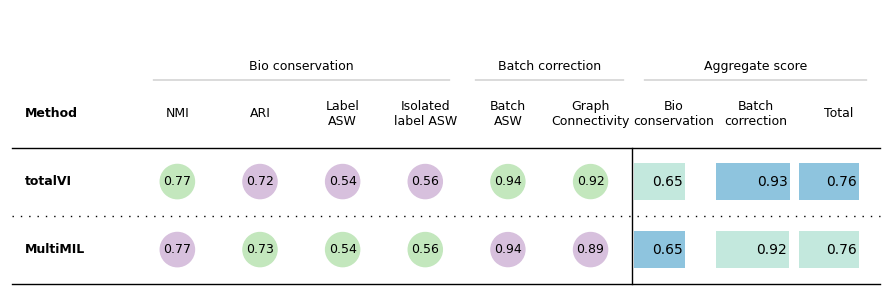

In [61]:
num_embeds = len(plot_df)

# Allow to manipulate text post-hoc (in illustrator)
with matplotlib.rc_context({"svg.fonttype": "none"}):
    fig, ax = plt.subplots(figsize=(len(df.columns) * 1.25, 3 + 0.3 * num_embeds))
    tab = Table(
        plot_df,
        cell_kw={
            "linewidth": 0,
            "edgecolor": "k",
        },
        column_definitions=column_definitions,
        ax=ax,
        row_dividers=True,
        footer_divider=True,
        textprops={"fontsize": 9, "ha": "center"},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},
        index_col="Method",
    ).autoset_fontcolors(colnames=plot_df.columns)

plt.savefig('figures/scib_table_pbmc_full_mtm_totalvi.svg', bbox_inches='tight')

plt.show()